## RNN Implementation

#### Temporary, for convenience

DECISIONS:
1. Calculate the drawdown and assign days with drawdown in the 99.5% quantile as crash (i.e. label=1). 
2. The target is shift 3 days to make the problem as "Predict if there will be a market crash 3 days later".



To-do: 
- More Plots?
- Add data
- more hyperparameter search
- better accuracy



### Data and imports   

#### Imports

In [ ]:
import numpy as np
import yfinance as yf # to get our data


from sklearn.preprocessing import MinMaxScaler # to normalize our classes
from sklearn.model_selection import train_test_split # from tutorial code
from sklearn.metrics import accuracy_score, confusion_matrix # needed for plotting
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt # for plotting

import warnings
warnings.filterwarnings("ignore")

#### Get Data from Yahoo Finance

In [2]:
dfs = {} # Store all the data for our tickers, even though for now its just SP500
tickers = ['^GSPC',] # Ticker (identifier) for the SP500, which is arguably the most influential, we start with just this

# Got this code from https://www.kaggle.com/code/xxxxyyyy80008/predict-stock-market-crashes 
for ticker in tickers:
    cur_data = yf.Ticker(ticker)
    hist = cur_data.history(period="max")
    print(ticker, cur_data.info['shortName'], ticker, hist.shape, hist.index.min(), hist.index.max())
    dfs[ticker] = hist

^GSPC S&P 500 ^GSPC (24350, 7) 1927-12-30 00:00:00-05:00 2024-12-05 00:00:00-05:00


### Database and Preprocessing

#### Hyperparameters 

In [3]:
SEQUENCE_LENGTH = 15 # how large our window is
TEST_SIZE = 0.2
EPOCHS = 20
BATCH_SIZE = 20
SHIFT_DAYS = 3 # how far ahead we want to predict market crashes

#### Database creation

In [4]:
# Calculates how much the price has gone down from its highest point, labeling those with a 0.005 quantile as crashes as per directive 1
# NOTE: got help from chatgpt for this function to find .pct_change, .cummax and .quantile
def calculate_drawdown_and_label(data, quantile_threshold=0.005):

    data['daily_return'] = data['Close'].pct_change()

    data['drawdown'] = data['Close'] / data['Close'].cummax() - 1

    crash_threshold = data['drawdown'].quantile(quantile_threshold)

    data['crash_label'] = (data['drawdown'] < crash_threshold).astype(int)

    return data

## Make the data we targetted the target (nice), we try to predict the market crashes 3 days in advance so shift_days = 3
def prepare_target(data, shift_days=3):
    data['target'] = (data['crash_label']).astype(int).shift(-shift_days) # complicated line that basically takes our data with crash label, turns the bools into an int, then shift the values by 3 days to predict in advance, since we want to predict 3 days in advance
    return data

# prep the data
for ticker, data in dfs.items():
    data = calculate_drawdown_and_label(data) # get the drawdown for our data
    data = prepare_target(data, SHIFT_DAYS)
    dfs[ticker] = data


# Database done


#### Preprocessing

In [5]:
def preprocess_data(data, sequence_length=15): # data is our data we

    scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize our features between 0 and 1 to make sure its all the same, since prices and dropdown are very much not all on scale.
    scaled_data = scaler.fit_transform(data[['Close', 'daily_return', 'drawdown']].dropna()) # our simple features we defined before + the ones from hist, scale them and create. .dropna removes the rows that have features which are nan i.e. rows with missing features

    X = []
    y = []

    for i in range(len(scaled_data) - sequence_length): # process data by sequences of days to learn. This is a window, so we go from one day to the next. for example, if we have day 1 to day 15 on iteration i, at iteration i + 1 we have day 2 to 16. this window is a single datapoint within a single minibatch.
        days = scaled_data[i:i+sequence_length] # get the sequence of 15 days
        X.append(days) # add to x the data as sequences of 15 days
        y.append(data['target'].iloc[i + sequence_length]) # this is the target. It adds the value of the next sequence as the target, so we can predict future crashes

    X = np.array(X) # turn into array for processing
    y = np.array(y)
     
    
    y = y[~np.isnan(y)]  # remove nan of the last few data points, since we shift by 3 days the last few points. i.e. for day 1, the target is day 4 for three days. so at the end of the seuquence wed get 3 empty datapoints. 
    X = X[:len(y)]  # cut those data points which had no y, i.e. the last few days
    return X, y, scaler # return the scaler function to make sure when we process the test data and validation data, we can process the data before feeding it into our model




# now we process our data, here we do as if we had multiple tickers, in case we add more later
sequence_length = SEQUENCE_LENGTH # hyperparameter for the length of the window. 15 is completely arbirtrary here, need to adjust to get better or worst results.
X = {} # data of all the tickers
y = {} # labels of all the tickers
scalers = {} # scalers of all the tickers
for ticker, data in dfs.items(): #iterate through each ticker, datapoint and the dataframes (dfs) we got from yf, and preprocess them then add them to the dictionnary
    X[ticker], y[ticker], scalers[ticker] = preprocess_data(data, sequence_length=sequence_length) 

# Combine data from all our tickers, joining them on axis 0 i.e. we want to concatenate all the rows together
X_all = np.concatenate([X[ticker] for ticker in X], axis=0)
y_all = np.concatenate([y[ticker] for ticker in y], axis=0) # same thing for labels

# give 20% as test size, 80% for our training data. this functino was found in the tutorial ipynb
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=TEST_SIZE, random_state=42)

### ARIMA

#### Model

In [6]:
def forecast_arima(X_test, sequence_length, shift_days, threshold=0.005, p=5, d=1, q=0):
    predictions = []

    for i in range(len(X_test)):
       # make sure we ge tonly the sequence length
        if i + sequence_length > len(X_test):
            break  
        
        train_sequence = X_test[i, :, 0]  

        model = ARIMA(train_sequence, order=(p, q, d))  
        model_fit = model.fit()

        # clauclate the forecast on the next 3 days
        forecast = model_fit.forecast(steps=shift_days)

        # check the drawdown: NOTE: Got help
        forecast_drawdown = (np.array(forecast) / max(train_sequence) - 1)
        isit_crash = False
        for dd in forecast_drawdown: # check if anything is lower than the threshold
            if (dd < -threshold):
                isit_crash = True
                break
        
        predictions.append(1 if isit_crash == 1 else 0) # make it a crash if its 0

    return predictions

# Generate predictions on test data
#predictions = forecast_arima(X_test, sequence_length=SEQUENCE_LENGTH, shift_days=SHIFT_DAYS)
#confusion_matrix_var = confusion_matrix(y_test[:len(predictions)], predictions)

### Testing for stationarity

In [14]:
from statsmodels.tsa.stattools import adfuller

df = dfs['^GSPC']

adf_test = adfuller(df['Close'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('ADF p-value: %f' % adf_test[1])

from statsmodels.tsa.stattools import kpss
kpss_result = kpss(df['Close'])
print(f'KPSS result: {kpss_result[1]}')

ADF Statistic: 7.401900
ADF p-value: 1.000000
KPSS result: 0.01


From the ADF test and KPSS test result, our data is non-stationary, therefore the difference term $d$ is needed.

### PACF and ACF

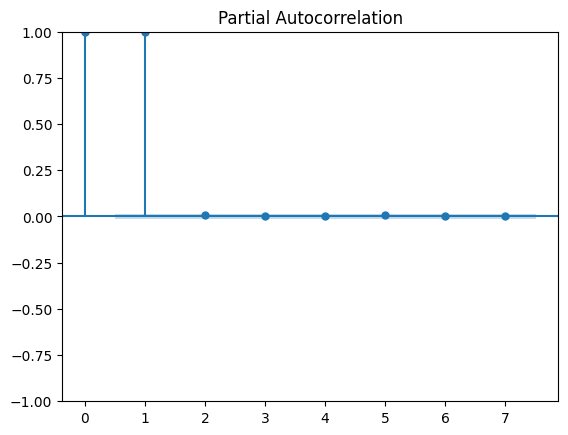

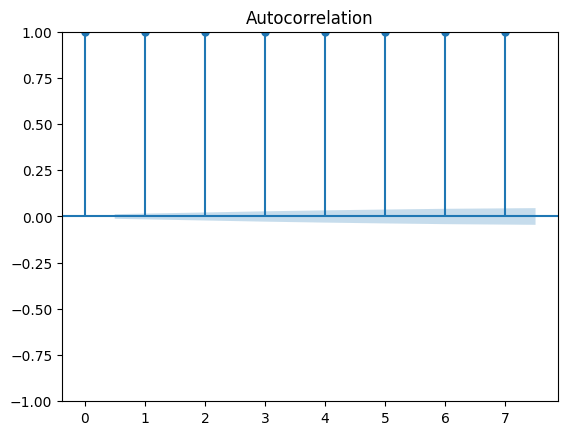

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = dfs['^GSPC']
plot_pacf(df['Close'], lags=7)
plot_acf(df['Close'], lags=7)
plt.show()

From PACF, we can choose either $p = 0$ or $p=1$. From ACF, it is hard to tell what should be the degree of $q$, so we will use a grid search on it.

### Grid search
We will run grid search on $p\in\{0,1\}, q\in\{0,1,2,3,4,5\}, d\in\{1,2\}$ to find out which set of hyperparameter will give the best accuracy.

In [ ]:
p, d, q = 0, 1, 0
best_hyperparameter = (0, 1, 0)
best_accuracy = 0
try: 
    while p <= 2:
        d = 1
        while d <= 2:
            q = 0
            while q <= 5:
                print(f'Hyperparameter: p={p}, d={d}, q={q}')
                predictions = forecast_arima(X_test, sequence_length=SEQUENCE_LENGTH, shift_days=SHIFT_DAYS, p=p, d=d, q=q)
                predictions_as_classes = np.array(predictions[:len(y_test)])
                accuracy = accuracy_score(y_test[:len(predictions)], predictions_as_classes)
                print(f'Accuracy: {accuracy}')
                if accuracy > best_accuracy:
                    best_hyperparameter = (p,d,q)
                    best_accuracy = accuracy
                q += 1
            d += 1
        p += 1
except np.linalg.LinAlgError:
    pass
print(f'Best hyperparameter: {best_hyperparameter}')
print(f'Accuracy: {best_accuracy}')


Hyperparameter: p=0, d=1, q=0
Accuracy: 0.010921079744487945
Hyperparameter: p=0, d=1, q=1
Accuracy: 0.3410261693797651
Hyperparameter: p=0, d=1, q=2
Accuracy: 0.37646816402225425
Hyperparameter: p=0, d=1, q=3
Accuracy: 0.3280445085514115
Hyperparameter: p=0, d=1, q=4
Accuracy: 0.35998351535132905
Hyperparameter: p=0, d=1, q=5
Accuracy: 0.41170410055635687
Hyperparameter: p=0, d=2, q=0
Accuracy: 0.009478672985781991
Hyperparameter: p=0, d=2, q=1
Accuracy: 0.2998145477024521
Hyperparameter: p=0, d=2, q=2
Accuracy: 0.37008036266227073
Hyperparameter: p=0, d=2, q=3
Accuracy: 0.3294869153101175
Hyperparameter: p=0, d=2, q=4
Accuracy: 0.3682258396867917
Hyperparameter: p=0, d=2, q=5
Accuracy: 0.4069647640634659
Hyperparameter: p=1, d=1, q=0
Accuracy: 0.06614465279208737
Hyperparameter: p=1, d=1, q=1
Accuracy: 0.33072326396043683
Hyperparameter: p=1, d=1, q=2
Accuracy: 0.3704924788790439
Hyperparameter: p=1, d=1, q=3
Accuracy: 0.3288687409849578
Hyperparameter: p=1, d=1, q=4
Accuracy: 0.3389

From the grid search, the best hyperparameter is $p, d, q = 0, 1, 5$. With $41.17\%$ of accuracy. Let's make run the model again with these hyperparameter.

In [16]:
predictions = forecast_arima(X_test, sequence_length=SEQUENCE_LENGTH, shift_days=SHIFT_DAYS, p=0, d=1, q=5)
predictions_as_classes = np.array(predictions[:len(y_test)])
accuracy = accuracy_score(y_test[:len(predictions)], predictions_as_classes)
print(f'Accuracy: {accuracy}')

Accuracy: 0.41170410055635687


#### Plotting

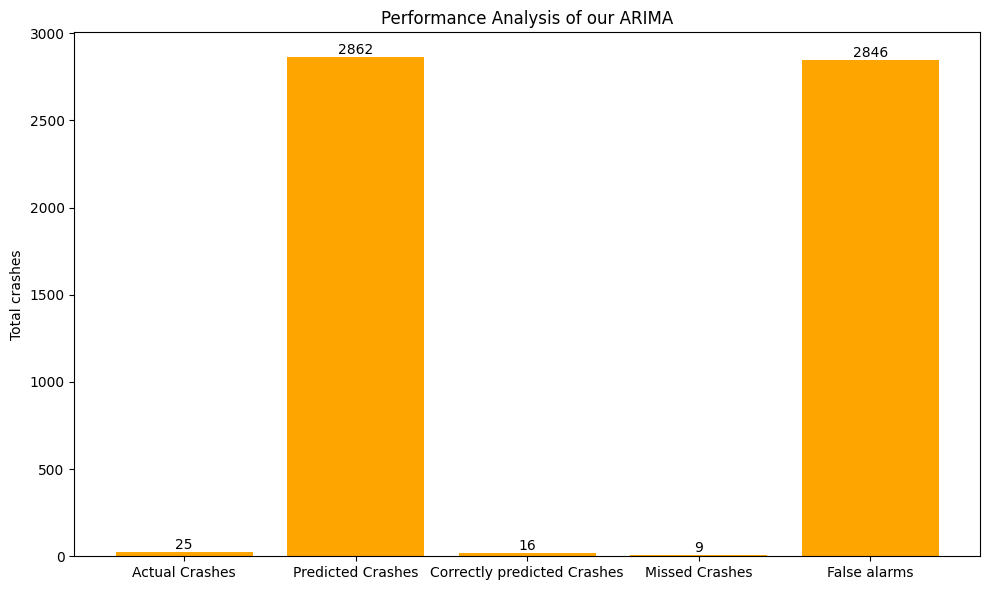

In [ ]:
confusion_matrix_var = confusion_matrix(y_test[:len(predictions)], predictions)
real_crashes = int(sum(y_test == 1)) # crashes in our test data
predicted_crashes = int((predictions_as_classes == 1).sum()) # crashes are 1 in our predictions
predicted_correctly = int(confusion_matrix_var[1, 1])  # tp in our confusion matrix
missed_crashes = int(confusion_matrix_var[1, 0])  # fn in our confusion matrix
predicted_when_there_wasnt = int(confusion_matrix_var[0, 1])  # fp in our confusion matrix

categories = [
    "Actual Crashes",
    "Predicted Crashes",
    "Correctly predicted Crashes",
    "Missed Crashes",
    "False alarms"
]
values = [
    real_crashes,
    predicted_crashes,
    predicted_correctly,
    missed_crashes,
    predicted_when_there_wasnt,
]


plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color='orange')
plt.title("Performance Analysis of our ARIMA")
plt.ylabel("Total crashes")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


We can see that the accuracy is not high with lots of false alarms

### Experiments with day shifts and sliding windows
We are going to test the arima model with different day shifts on the data and sliding windows.
1.
2.